# Investigating The Kinematics and Kinetics of Baseball Hitting
### William Zhao

##### https://www.openbiomechanics.org/ 
##### By: Wasserberger KW, Brady AC, Besky DM, Jones BR, Boddy KJ. The OpenBiomechanics Project: The open source initiative for anonymized, elite-level athletic motion capture data. (2022).

##### This was another small project done as an opportunity to practice my programming skills as well as to try my hand at using statistical parametric mapping. The goal of this project was to to investigate the differences in the 'kinematic sequence', which I have loosely defined as the segment angular velocities of four segments, between fast, slow, and average exit velocities. 
##### Since the majority of baseball research has seemingly been centered around pitching, I decided to focus this project on hitting out of personal interest!

In [11]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import CubicSpline
import spm1d

## Get data
landmarks = pd.read_csv("C:\\Users\\Willi\\OneDrive\\Desktop\\Data Science Learning\\Baseball Data Project\\Hitting Data\\landmarks.csv")
joint_velos = pd.read_csv("C:\\Users\\Willi\\OneDrive\\Desktop\\Data Science Learning\\Baseball Data Project\\Hitting Data\\joint_velos\\joint_velos.csv")
force_plate = pd.read_csv("C:\\Users\\Willi\\OneDrive\\Desktop\\Data Science Learning\\Baseball Data Project\\Hitting Data\\force_plate.csv")
joint_angles = pd.read_csv("C:\\Users\\Willi\\OneDrive\\Desktop\\Data Science Learning\\Baseball Data Project\\Hitting Data\\joint_angles\\joint_angles.csv")
metadata = pd.read_csv("C:\\Users\\Willi\\OneDrive\\Desktop\\Data Science Learning\\Baseball Data Project\\Hitting Data\\metadata.csv")
poi_metrics = pd.read_csv("C:\\Users\\Willi\\OneDrive\\Desktop\\Data Science Learning\\Baseball Data Project\\Hitting Data\\poi_metrics.csv")

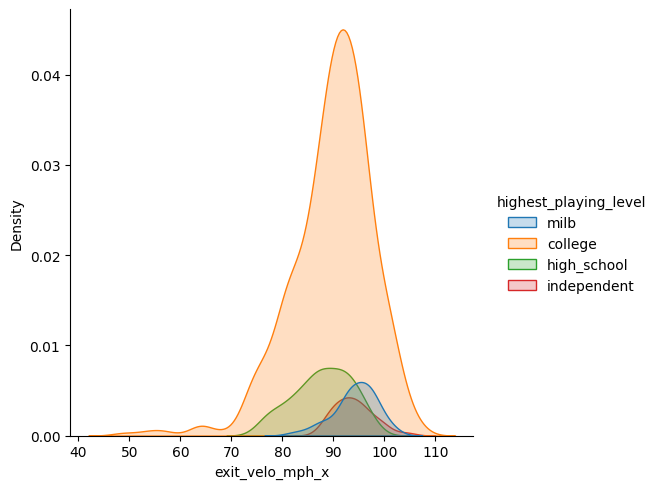

89.9186011904762
7.5547891942250045


In [13]:
## Visualize distribution of exit velocity
sns.displot(metadata , x = 'exit_velo_mph_x' , hue = 'highest_playing_level' , kind = 'kde' , fill = 'True')
plt.show()

## Calculate mean and standard deviation of exit velocity
mean_exit_velo = metadata['exit_velo_mph_x'].mean()
sd_exit_velo = metadata['exit_velo_mph_x'].std()
print(mean_exit_velo)
print(sd_exit_velo)

**From visualizing the distribution of exit velocity by playing level and calcualting the mean and standard deviation of exit velocity, we can see that the majority of the sample comes from college athletes and that the mean exit velocity of the group is ~90 mph.**

**I calculated the mean and standard deviation of exit velocity for the group to inform which session swings would be included in this small analysis. In the end, I selected 15 swings in total where 5 fell within the average exit velocity range, 5 were within the fast exit velocity range which I defined as at least 1SD above the average, and 5 were within the slow exit velocity range which I defined as at least 1SD below the average.**



In [4]:
## Extract all data associated with select swing_ids
avg_session_swing = ['474_4', '474_7', '43_4', '121_3', '199_2']
fast_session_swing = ['179_7', '282_5', '42_3', '42_5', '291_7']
slow_session_swing = ['287_6', '451_2', '123_1', '123_5', '123_6']

avg_joint_velos = joint_velos[joint_velos['session_swing'].isin(avg_session_swing)]
avg_force_plate = force_plate[force_plate['session_swing'].isin(avg_session_swing)]
avg_poi_metrics = poi_metrics[poi_metrics['session_swing'].isin(avg_session_swing)]
avg_landmarks = landmarks[landmarks['session_swing'].isin(avg_session_swing)]

fast_joint_velos = joint_velos[joint_velos['session_swing'].isin(fast_session_swing)]
fast_force_plate = force_plate[force_plate['session_swing'].isin(fast_session_swing)]
fast_poi_metrics = poi_metrics[poi_metrics['session_swing'].isin(fast_session_swing)]
fast_landmarks = landmarks[landmarks['session_swing'].isin(fast_session_swing)]

slow_joint_velos = joint_velos[joint_velos['session_swing'].isin(slow_session_swing)]
slow_force_plate = force_plate[force_plate['session_swing'].isin(slow_session_swing)]
slow_poi_metrics = poi_metrics[poi_metrics['session_swing'].isin(slow_session_swing)]
slow_landmarks = landmarks[landmarks['session_swing'].isin(slow_session_swing)]

## Create a table that compares the POI metrics of the 3 swings 
combined_poi_metrics = pd.concat([fast_poi_metrics , avg_poi_metrics, slow_poi_metrics] , ignore_index = True)
print(combined_poi_metrics[['session_swing' , 'exit_velo_mph_x']])

   session_swing  exit_velo_mph_x
0          179_7            106.7
1          282_5            107.0
2          291_7            104.2
3           42_3            104.8
4           42_5            104.8
5          121_3             89.8
6          199_2             89.9
7           43_4             91.7
8          474_4             89.9
9          474_7             89.9
10         123_1             74.6
11         123_5             74.5
12         123_6             74.1
13         287_6             74.8
14         451_2             74.3


**As we can see, there is a clear difference in the exit velocity between each set of 5 swings, and so my next steps will be geared towards trying to investigate what made them differ.**
*As a note, all swings were from righty hitters, and they were all from the college playing level*

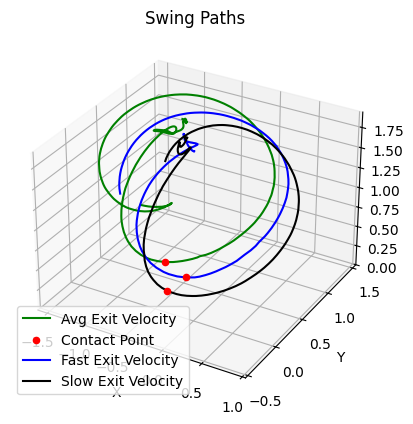

In [5]:
## Visualize 3 swings in 3D space
swing_avg_landmarks = avg_landmarks[avg_landmarks['session_swing'] == '474_4']
swing_fast_landmarks = fast_landmarks[fast_landmarks['session_swing'] == '179_7']
swing_slow_landmarks = slow_landmarks[slow_landmarks['session_swing'] == '287_6']

def plot_swing (*landmarks_list):
    """
    Function to generate 3D visualizations of swing path
    """
    fig = plt.figure()
    ax = plt.axes(projection = '3d')
    colors = ['green', 'blue', 'black']
    titles = ['Avg Exit Velocity' , 'Fast Exit Velocity' , 'Slow Exit Velocity']
    
    for i, landmarks in enumerate(landmarks_list):
        # Plot the swing path
        ax.plot3D(landmarks['sweet_spot_x'], landmarks['sweet_spot_y'], landmarks['sweet_spot_z'], color=colors[i], label=titles[i])
        
        contact_time = landmarks['contact_time'].iloc[0]
        idx = np.argwhere(landmarks['time'] == contact_time).flatten()
        
        # Plot the contact point for each swing
        ax.scatter(landmarks['sweet_spot_x'].iloc[idx],
                   landmarks['sweet_spot_y'].iloc[idx],
                   landmarks['sweet_spot_z'].iloc[idx],
                   color='red', label='Contact Point' if i == 0 else "")  # Only label contact point for the first swing
        
    ax.set_zlim(zmin = 0)
    ax.legend()
    ax.set_title('Swing Paths')
    ax.set_ylabel('Y')
    ax.set_xlabel('X')
    plt.show()
    
plot_swing(swing_avg_landmarks, swing_fast_landmarks, swing_slow_landmarks)

**The first step I took was to visualize 3 swings in 3D space to gain a sense of whether there were significant differences in the contact points. From the 3 chosen swings, it does seem that the 'fast exit velocity' swing had an earlier contact point, which could be caused by a faster bat speed.**

**The next step I took was to split the swing into 2 phases: the prep phase defined as the start to front foot contact, and the swing phase defined as front foot contact to ball contact.**

**I also time normalized the kinematic and kinetic data in the swing phase to 101 data points to allow for comparisons between swings**

In [6]:
## Extract phases of swing
def split_phases_by_swing_id(df):
    """
    Function to split phases of the swing for each unique swing_id.
    """
    prep_phases = {}
    swing_phases = {}

    for swing_id in df['session_swing'].unique():
        swing_df = df[df['session_swing'] == swing_id]
        fp_10 = swing_df['fp_10_time'].iloc[0]
        contact = swing_df['contact_time'].iloc[0]
        
        # Split the data for the current swing_id
        prep_phase = swing_df[swing_df['time'] < fp_10]
        swing_phase = swing_df[(swing_df['time'] >= fp_10) & (swing_df['time'] <= contact)]
        
        # Store the results in dictionaries
        prep_phases[swing_id] = prep_phase
        swing_phases[swing_id] = swing_phase

    return prep_phases, swing_phases

# Apply function for average, fast, and slow sessions
prep_avg_joint_velos, swing_avg_joint_velos = split_phases_by_swing_id(avg_joint_velos)
prep_fast_joint_velos, swing_fast_joint_velos = split_phases_by_swing_id(fast_joint_velos)
prep_slow_joint_velos, swing_slow_joint_velos = split_phases_by_swing_id(slow_joint_velos)

prep_avg_force_plate, swing_avg_force_plate = split_phases_by_swing_id(avg_force_plate)
prep_fast_force_plate, swing_fast_force_plate = split_phases_by_swing_id(fast_force_plate)
prep_slow_force_plate, swing_slow_force_plate = split_phases_by_swing_id(slow_force_plate)

## Normalize Segment Velocities
def normalize_segment_velocity(data, joint_column):
    """
    Normalizes segment velocity for a specific joint in the provided data.
    """
    # Extract time parameters
    start_time = data['time'].iloc[0]
    end_time = data['time'].iloc[-1]
    time_step = (end_time - start_time) / len(data)

    # Retrieve time points
    time_points = np.arange(start_time, end_time, time_step)

    # Adjust data values as needed for specific joints
    joint_velocity = np.abs(data[joint_column]) if 'lead_shoulder' in joint_column or 'lead_hand' in joint_column else data[joint_column]

    # Create a spline for interpolation
    spline = CubicSpline(time_points, joint_velocity)

    # Generate a normalized time series and interpolated data
    time_normalized = np.linspace(time_points[0], time_points[-1], 101)
    data_normalized = spline(time_normalized)

    # Create a DataFrame to store normalized data
    norm_velos = pd.DataFrame({'time_normalized': time_normalized, 'data_normalized': data_normalized})

    return norm_velos

# Define swing speeds, joint columns, colors, and labels
swing_speed = {
    'fast' : swing_fast_joint_velos,
    'avg' : swing_avg_joint_velos,
    'slow' : swing_slow_joint_velos
}
    
joints = {
    'pelvis': ('pelvis_angular_velocity_z'),
    'torso': ('torso_angular_velocity_z'),
    'arm': ('lead_shoulder_global_angular_velocity_x'),
    'hand': ('lead_hand_global_angular_velocity_y')
}

# Dictionary to hold normalized velocities for each swing speed and joint
norm_velos = {}

# Process each swing speed and joint
for speed, data_dict in swing_speed.items():
    for swing_id, data in data_dict.items():  # Iterate over each swing_id's DataFrame
        for joint, (column) in joints.items():
            # Normalize the data for the current joint
            normalized_df = normalize_segment_velocity(data, column)
            norm_velos[(speed, swing_id, joint)] = normalized_df  # Save in nested dictionary format

## Normalize Ground Reaction Forces
def normalize_force(data, force_column, swing_speed):
    """
    Normalizes GRF for a specific force in the provided data.
    """
    #Extract time parameters
    start_time = data['time'].iloc[0]
    end_time = data['time'].iloc[-1]
    time_step = (data['time'].iloc[-1] - data['time'].iloc[0]) / len(data)
    
    #Retreive time points
    time_points = np.arange(start_time , end_time , time_step)
    
    #Retrieve and adjust data values
    force = data[force_column]
    
    #Create a spline for interpolation
    spline = CubicSpline(time_points , force)
    
    #Generate a normalized time series and interpolated data
    time_normalized = np.linspace(time_points[0], time_points[-1] , 101)
    data_normalized = spline(time_normalized)
    
    # Create a df to store normalized data
    norm_force = pd.DataFrame({'time_normalized': time_normalized, 'data_normalized': data_normalized})
   
    return norm_force
    
# Define swing speeds, force
swing_speed = {
    'fast' : swing_fast_force_plate,
    'avg' : swing_avg_force_plate,
    'slow' : swing_slow_force_plate
}
    
force = {
    'lead_force': ('lead_force_z'),
    'rear_force': ('rear_force_z')
}

# Call function to normalize force
norm_force = {}

for speed, data_dict in swing_speed.items():
    for swing_id, data in data_dict.items():  # Iterate over each swing_id's DataFrame
        for force_type, column in force.items():
            # Normalize the data 
            normalized_df = normalize_force(data, column, speed)
            # Store the result with a multi-key tuple to distinguish by speed, force type, and swing_id
            norm_force[(speed, force_type, swing_id)] = normalized_df

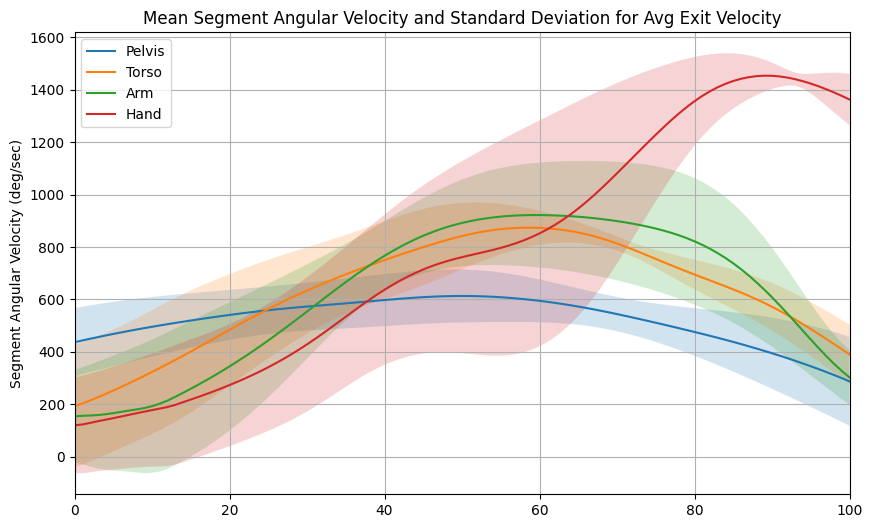

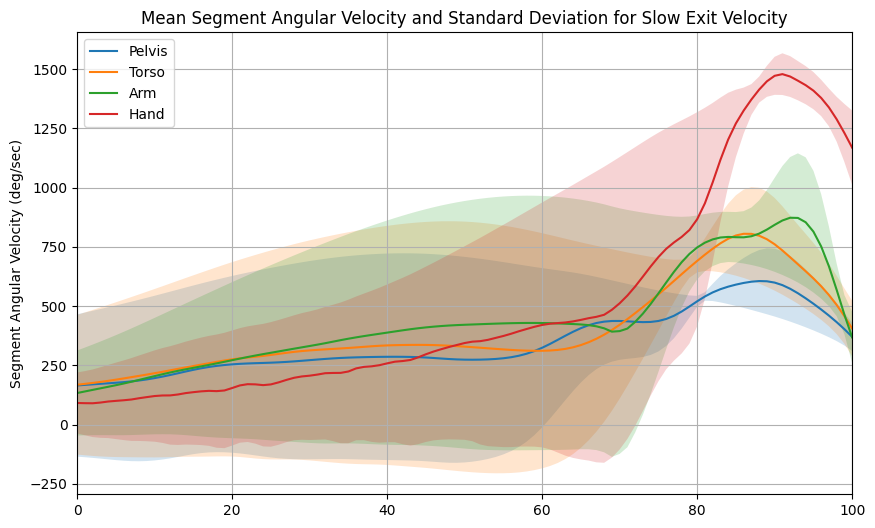

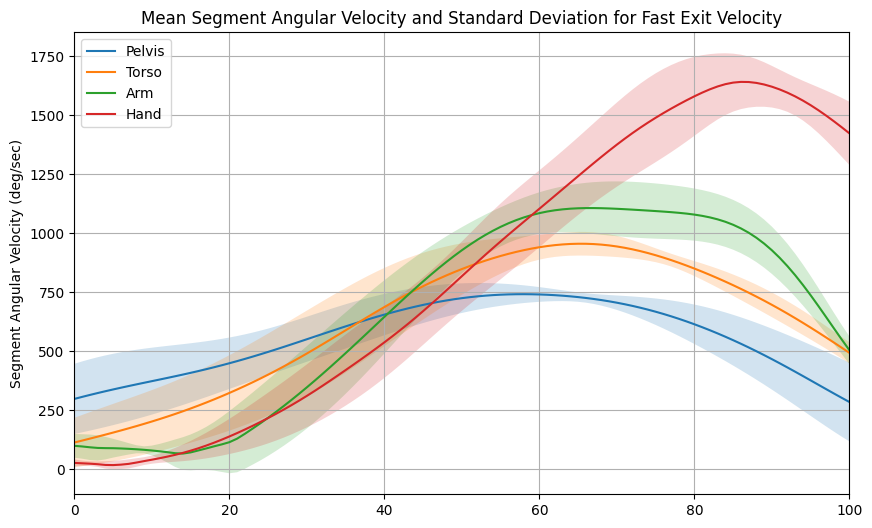

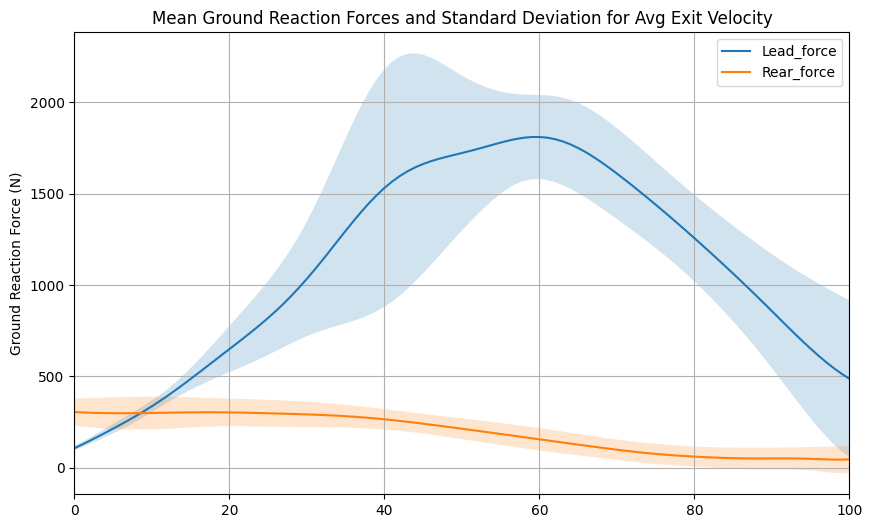

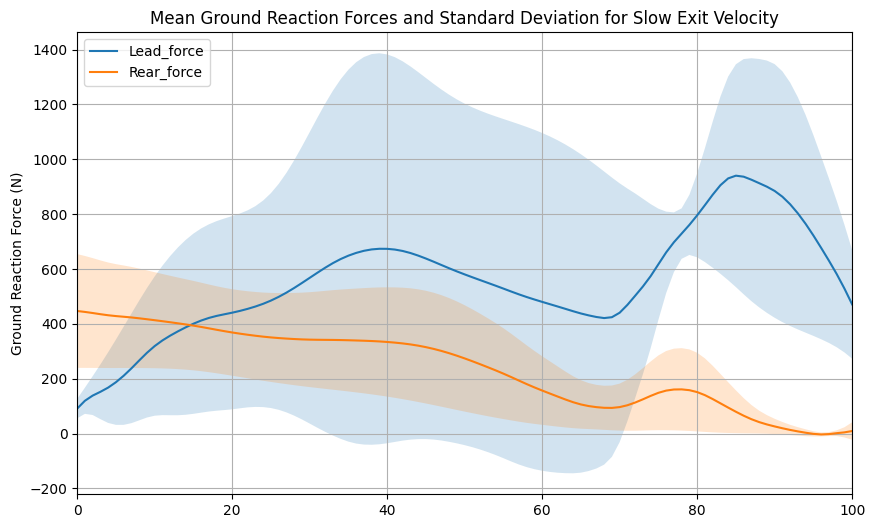

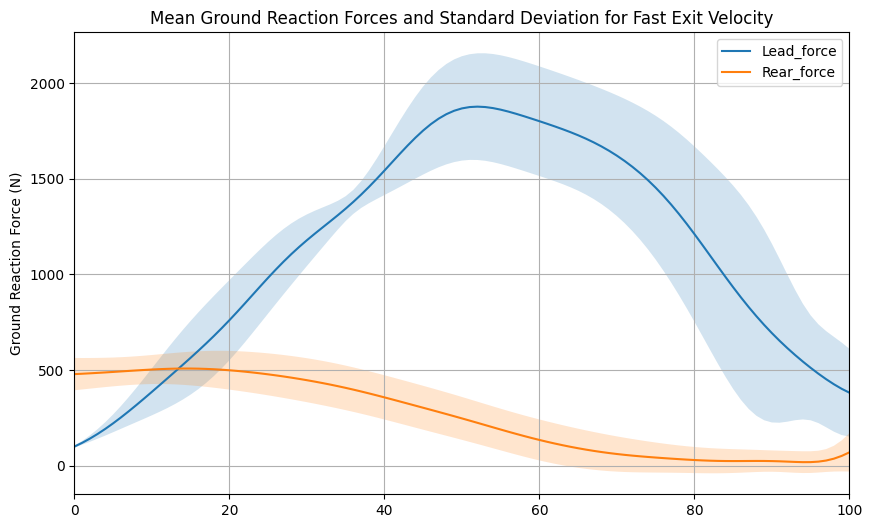

In [7]:
## Plotting

speed_keys = ['slow', 'avg', 'fast']
segment_keys = ['pelvis', 'torso', 'arm', 'hand']
force_keys = ['lead_force' , 'rear_force']

# Prepare a dictionary to store normalized velos from each athlete
concatenated_velos = {}
concatenated_forces = {}

# Loop through norm_velos to concatenate data
for speed_key in speed_keys:
    for segment_key in segment_keys:
        # List to hold DataFrames for current speed and segment combination
        columns = []
        
        # Loop through the dictionary to find matching keys
        for subject_id in set(key[1] for key in norm_velos.keys()):  # Get unique subject IDs
            key = (speed_key, subject_id, segment_key)  # Construct the key
            if key in norm_velos:  # Check if the constructed key exists
                df = norm_velos[key]
                columns.append(df.iloc[:, 1])  # Append the 2nd column from each df
        
        # If we have DataFrames for this combination, concatenate and store
        if columns:
            combined_df = pd.concat(columns, axis = 1)  # Combine DataFrames
            concatenated_velos[(speed_key, segment_key)] = combined_df  # Store in dictionary
            
# Loop through norm_force to concatenate data
for speed_key in speed_keys:
    for force_key in force_keys:
        # List to hold DataFrames for current speed and segment combination
        columns = []
        
        # Loop through the dictionary to find matching keys
        for subject_id in set(key[2] for key in norm_force.keys()):  # Get unique subject IDs
            key = (speed_key, force_key, subject_id)  # Construct the key
            if key in norm_force:  # Check if the constructed key exists
                df = norm_force[key]
                columns.append(df.iloc[:, 1])  # Append the 2nd column from each df
        
        # If we have DataFrames for this combination, concatenate and store
        if columns:
            combined_df = pd.concat(columns, axis = 1)  # Combine DataFrames
            concatenated_forces[(speed_key, force_key)] = combined_df  # Store in dictionary

#Prepare a dictionary to store mean and std for normalized velos
mean_velos = {}
std_velos = {}

#Loop through concatenated_velos to average data
for key, df in concatenated_velos.items():
    #Calculate the row-wise mean
    mean_column = df.mean(axis = 1)
    
    #Create new DataFrame to store the result
    mean_velo = pd.DataFrame({'Mean' : mean_column})
    mean_velos[key] = mean_velo  

#Loop through concatenated_velos to calcualte stdev
for key, df in concatenated_velos.items():
    #Calculate the row-wise mean
    std_column = df.std(axis = 1)
    
    #Create new DataFrame to store the result
    std_velo = pd.DataFrame({'St Dev' : std_column})
    std_velos[key] = std_velo

#Prepare a dictionary to store mean and std for normalized force
mean_forces = {}
std_forces = {}

#Loop through concatenated_forces to average data
for key, df in concatenated_forces.items():
    #Calculate the row-wise mean
    mean_column = df.mean(axis = 1)
    
    #Create new DataFrame to store the result
    mean_force = pd.DataFrame({'Mean' : mean_column})
    mean_forces[key] = mean_force  

#Loop through concatenated_forces to calculate stdev
for key, df in concatenated_forces.items():
    #Calculate the row-wise mean
    std_column = df.std(axis = 1)
    
    #Create new DataFrame to store the result
    std_force = pd.DataFrame({'St Dev' : std_column})
    std_forces[key] = std_force

#Plot segment angular velocity of each exit velocity
speed_keys = ['avg', 'slow', 'fast']
segment_keys = ['pelvis', 'torso', 'arm', 'hand']

for speed in speed_keys:
    plt.figure(figsize = (10,6))
    plt.xlabel('Time (%)')
    plt.ylabel('Segment Angular Velocity (deg/sec)')
    plt.title(f"Mean Segment Angular Velocity and Standard Deviation for {speed.capitalize()} Exit Velocity")
    
    #Loop through each segment for the current speed
    for segment in segment_keys:
        key = (speed, segment)
        
        #Key will exist in both dictionaries
        if key in mean_velos and key in std_velos:
            mean_values = mean_velos[key]['Mean']
            std_values = std_velos[key]['St Dev']
            
            #Plot the mean line for each segment
            plt.plot(mean_values.index, mean_values, label = f"{segment.capitalize()}")
            
            #Add shaded area for the standard deviation
            plt.fill_between(mean_values.index,
                             mean_values - std_values,
                             mean_values + std_values,
                             alpha = 0.2)
    plt.xlim(0,100)
    plt.legend()
    plt.grid(True)
    plt.show()

#Plot force of each exit velocity
for speed in speed_keys:
    plt.figure(figsize = (10,6))
    plt.xlabel('Time (%)')
    plt.ylabel('Ground Reaction Force (N)')
    plt.title(f"Mean Ground Reaction Forces and Standard Deviation for {speed.capitalize()} Exit Velocity")
    
    #Loop through each segment for the current speed
    for force in force_keys:
        key = (speed, force)
        
        #Key will exist in both dictionaries
        if key in mean_forces and key in std_forces:
            mean_values = mean_forces[key]['Mean']
            std_values = std_forces[key]['St Dev']
            
            #Plot the mean line for each segment
            plt.plot(mean_values.index, mean_values, label = f"{force.capitalize()}")
            
            #Add shaded area for the standard deviation
            plt.fill_between(mean_values.index,
                             mean_values - std_values,
                             mean_values + std_values,
                             alpha = 0.2)
    plt.xlim(0,100)
    plt.legend()
    plt.grid(True)
    plt.show()

**For the purpose of this analysis, I decided to solely focus on the swing phase as that is where I believe the majority of the kinematic sequence occurs.**

**Upon visualizing the segment angular velocities between exit speeds, we can see a really interesting relationship where the swings that resulted in the fast exit velocities exhibited much less variability in magnitude and timing of peaks compared to the average and slow exit velocity swings.**
**To reinforce this, we also see much less variability in the lead and rear leg ground reaction forces in the fast exit velocity swings as well! Additionally, within the ground reaction forces we can see that the majority of the force production into the ground occurs in the lead leg during the swing phase.**

**All of this supports what we likely already know, that part of effective hitting stems from a sequence of peak angular velocities that start from the pelvis, travel through the torso, and ultimately end at the arm and hand. There is also likely a transfer of force production from the rear leg to the lead leg over the course of the entire swing, however that is not within the scope of this analysis.**

**Now, to try and understand where exactly the differences lie in the kinematic sequence between the slow, average, and fast exit velocity swings, I wanted to use statistical parametric mapping (SPM) as a way to analyze the whole time-varying signal rather than extracting discrete points in time.**

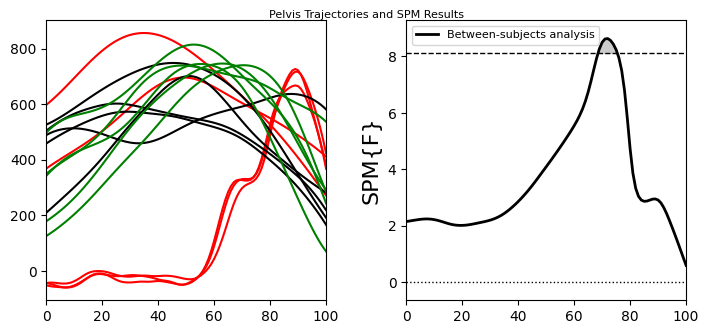

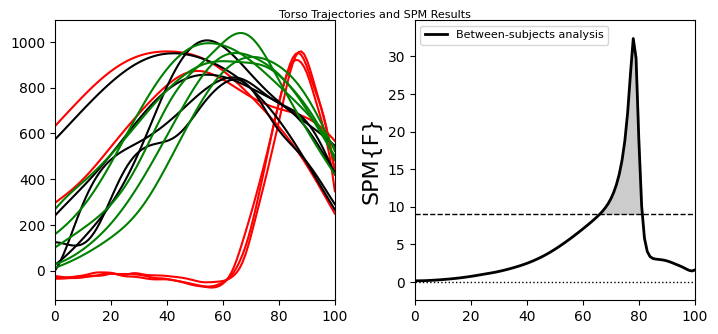

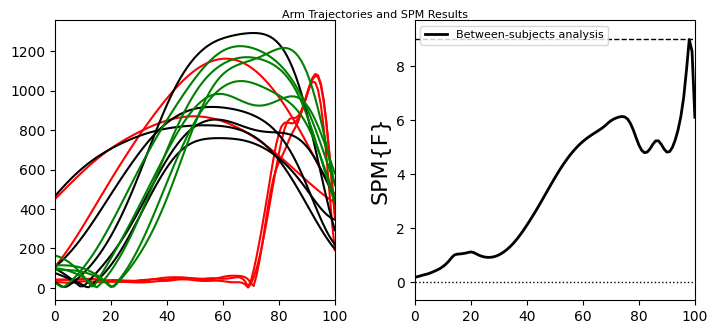

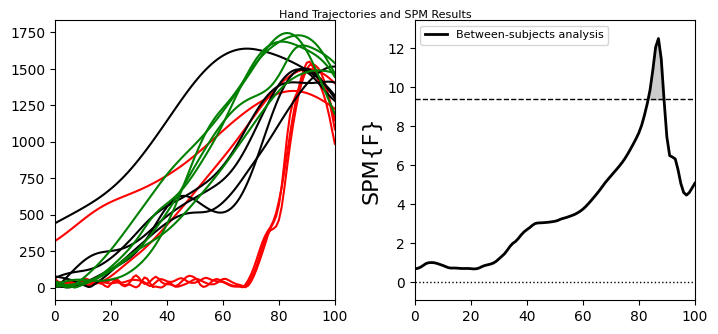

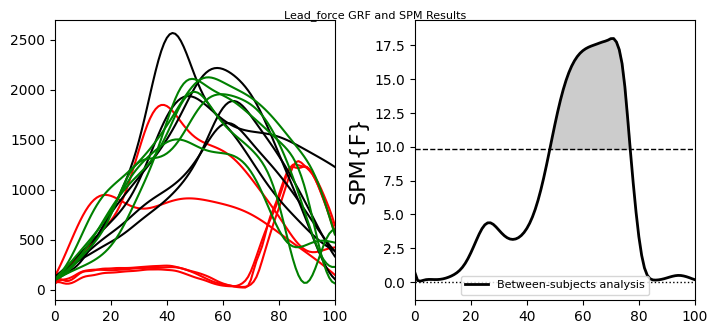

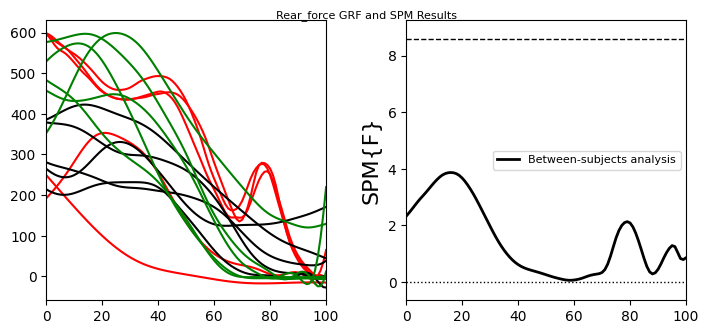

In [9]:
## SPM
def SPM_segment_velocity(segment_name, norm_velos):
    """
    Peforms a One-Way ANOVA SPM on time normalized segment angular velos
    """
    #Gather data for each speed category
    data = [np.vstack([norm_velos[key].iloc[:, 1] for key in norm_velos.keys()
                       if key[0] == speed and key [2] == segment_name])
            for speed in ['slow', 'avg', 'fast']]
    Y = np.vstack(data)
    A = np.repeat(np.arange(1, 4), 5)
    
    
    #SPM ANOVA
    alpha = 0.05
    equal_var = True
    F = spm1d.stats.anova1(Y, A, equal_var)
    Fi = F.inference(alpha)
    
    #Plot
    plt.close('all')
    plt.figure(figsize=(8, 3.5))
    ax0 = plt.axes((0.1, 0.15, 0.35, 0.8))
    ax1 = plt.axes((0.55, 0.15, 0.35, 0.8))
    plt.suptitle(f'{segment_name.capitalize()} Trajectories and SPM Results', fontsize=8)
    
    #Plot segment trajectories
    ax0.plot(Y[A == 1].T, 'r')
    ax0.plot(Y[A == 2].T, 'k')
    ax0.plot(Y[A == 3].T, 'g')
    ax0.set_xlim(0, 100)
    
    #Plot SPM result
    Fi.plot(ax=ax1, label='Between-subjects analysis')
    ax1.legend(fontsize=8)
    plt.show()
    
#Analyze each segment 
for segment in ['pelvis', 'torso', 'arm', 'hand']:
    SPM_segment_velocity(segment, norm_velos)


def SPM_force(force, norm_force):
    """
    Peforms a One-Way ANOVA SPM on time normalized GRFs
    """
    #Gather data for each spee category
    data = [np.vstack([norm_force[key].iloc[:, 1] for key in norm_force.keys()
                       if key[0] == speed and key [1] == force])
            for speed in ['slow', 'avg', 'fast']]
    Y = np.vstack(data)
    A = np.repeat(np.arange(1, 4), 5)
    
    #SPM ANOVA
    alpha = 0.05
    equal_var = True
    F = spm1d.stats.anova1(Y, A, equal_var)
    Fi = F.inference(alpha)
    
    #Plot
    plt.close('all')
    plt.figure(figsize=(8, 3.5))
    ax0 = plt.axes((0.1, 0.15, 0.35, 0.8))
    ax1 = plt.axes((0.55, 0.15, 0.35, 0.8))
    plt.suptitle(f'{force.capitalize()} GRF and SPM Results', fontsize=8)
    
    #Plot force
    ax0.plot(Y[A == 1].T, 'r')
    ax0.plot(Y[A == 2].T, 'k')
    ax0.plot(Y[A == 3].T, 'g')
    ax0.set_xlim(0, 100)
    
    #Plot SPM results
    Fi.plot(ax=ax1, label='Between-subjects analysis')
    ax1.legend(fontsize=8)
    plt.show()
#Analyze each force
for force in ['lead_force', 'rear_force']:
    SPM_force(force, norm_force)

**The results of the SPM reveal some really interesting insights! We see that there were significant differences in the segment angular velocities of the pelvis, torso, hand, and lead_force ground reaction force between the 3 exit velocity speeds. This would suggest that within those normalized periods of time in the swing phase, those variables were significantly different from each other between the 3 groups of athletes.** 

**Therefore, if we were trying to understand how an athlete in the 'slow' or 'avg' group could improve their exit velocity, this analysis would suggest that the timing and magnitude of the segment angular velocity of the pelvis, torso, and hand, alongside the lead leg ground reaction force are some variables we can begin diving deeper into.**


SPM{t} inference field
   SPM.z         :  (1x101) raw test stat field
   SPM.df        :  (1, 6.007)
   SPM.fwhm      :  30.91810
   SPM.resels    :  (1, 3.23435)
Inference:
   SPM.alpha     :  0.017
   SPM.zstar     :  5.74688
   SPM.h0reject  :  False
   SPM.p_set     :  1.000
   SPM.p_cluster :  ()





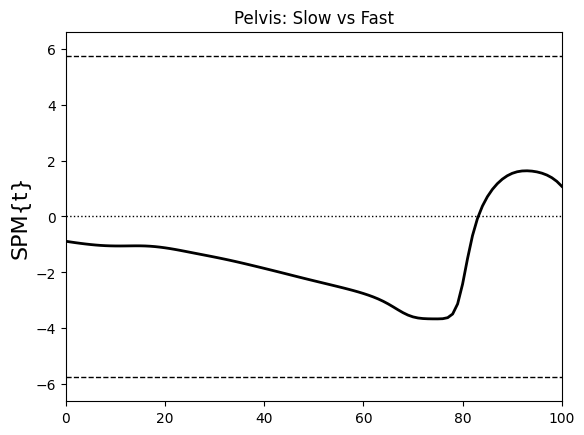

SPM{t} inference field
   SPM.z         :  (1x101) raw test stat field
   SPM.df        :  (1, 7.833)
   SPM.fwhm      :  31.76828
   SPM.resels    :  (1, 3.14779)
Inference:
   SPM.alpha     :  0.017
   SPM.zstar     :  4.78922
   SPM.h0reject  :  True
   SPM.p_set     :  0.012
   SPM.p_cluster :  (0.012)





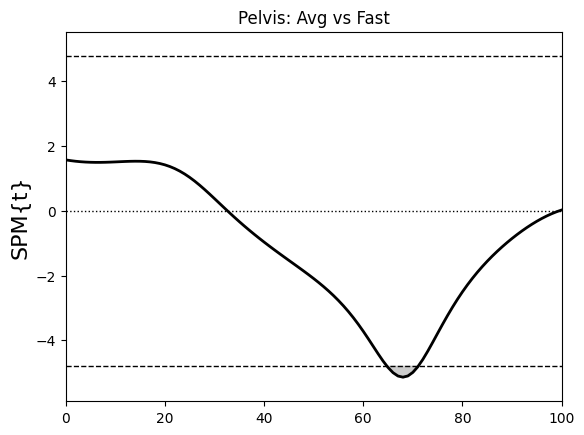

SPM{t} inference field
   SPM.z         :  (1x101) raw test stat field
   SPM.df        :  (1, 6.168)
   SPM.fwhm      :  31.84287
   SPM.resels    :  (1, 3.14042)
Inference:
   SPM.alpha     :  0.017
   SPM.zstar     :  5.59199
   SPM.h0reject  :  False
   SPM.p_set     :  1.000
   SPM.p_cluster :  ()





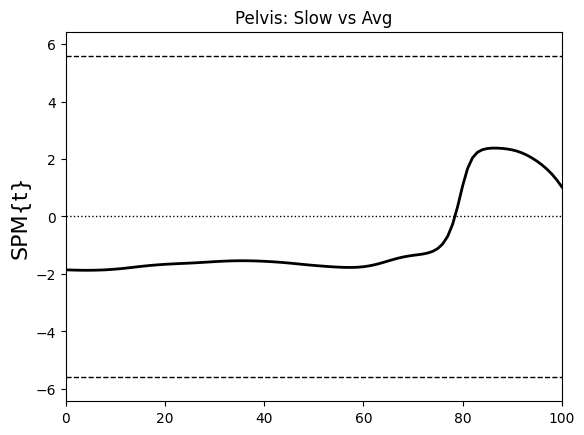

SPM{t} inference field
   SPM.z         :  (1x101) raw test stat field
   SPM.df        :  (1, 4.818)
   SPM.fwhm      :  21.84339
   SPM.resels    :  (1, 4.57804)
Inference:
   SPM.alpha     :  0.017
   SPM.zstar     :  7.82665
   SPM.h0reject  :  True
   SPM.p_set     :  0.015
   SPM.p_cluster :  (0.015)





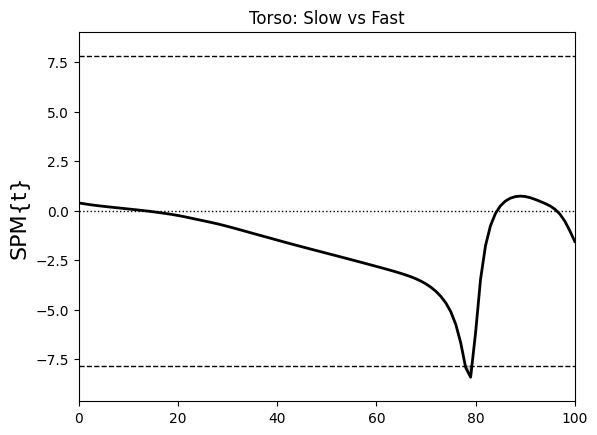

SPM{t} inference field
   SPM.z         :  (1x101) raw test stat field
   SPM.df        :  (1, 7.635)
   SPM.fwhm      :  24.56326
   SPM.resels    :  (1, 4.07112)
Inference:
   SPM.alpha     :  0.017
   SPM.zstar     :  5.08818
   SPM.h0reject  :  True
   SPM.p_set     :  0.002
   SPM.p_cluster :  (0.002)





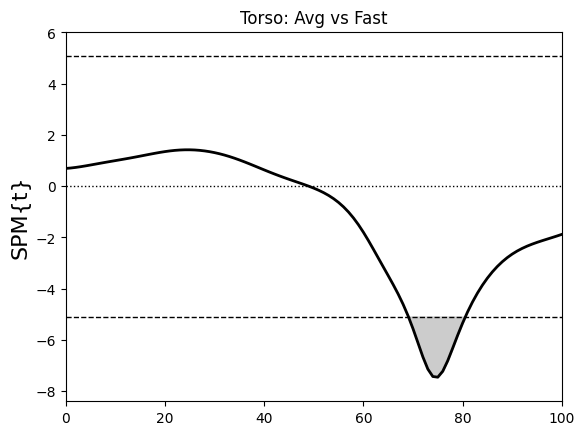

SPM{t} inference field
   SPM.z         :  (1x101) raw test stat field
   SPM.df        :  (1, 5.679)
   SPM.fwhm      :  23.33177
   SPM.resels    :  (1, 4.28600)
Inference:
   SPM.alpha     :  0.017
   SPM.zstar     :  6.42773
   SPM.h0reject  :  False
   SPM.p_set     :  1.000
   SPM.p_cluster :  ()





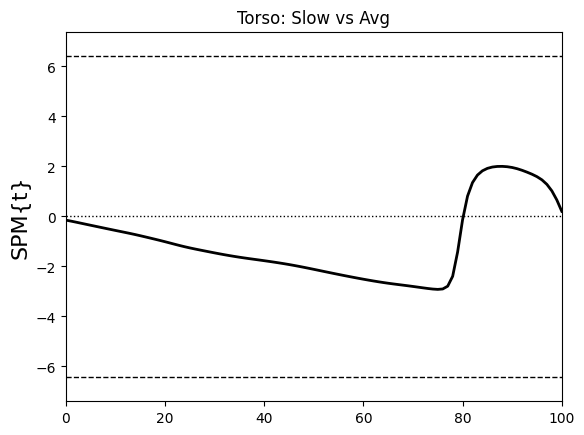

SPM{t} inference field
   SPM.z         :  (1x101) raw test stat field
   SPM.df        :  (1, 5.222)
   SPM.fwhm      :  19.58325
   SPM.resels    :  (1, 5.10640)
Inference:
   SPM.alpha     :  0.017
   SPM.zstar     :  7.31015
   SPM.h0reject  :  False
   SPM.p_set     :  1.000
   SPM.p_cluster :  ()





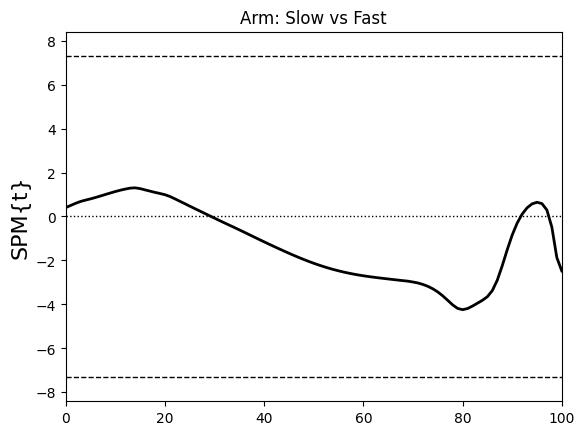

SPM{t} inference field
   SPM.z         :  (1x101) raw test stat field
   SPM.df        :  (1, 6.431)
   SPM.fwhm      :  29.27444
   SPM.resels    :  (1, 3.41595)
Inference:
   SPM.alpha     :  0.017
   SPM.zstar     :  5.51328
   SPM.h0reject  :  False
   SPM.p_set     :  1.000
   SPM.p_cluster :  ()





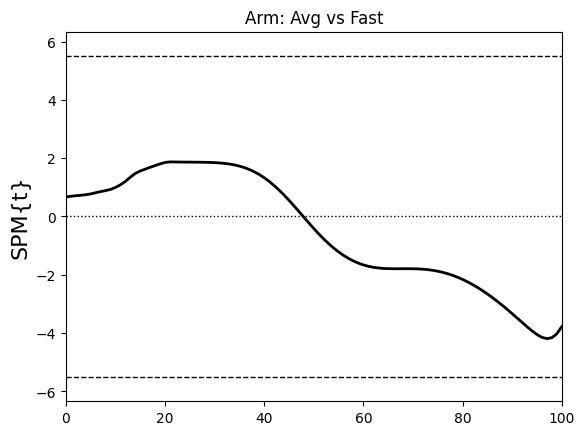

SPM{t} inference field
   SPM.z         :  (1x101) raw test stat field
   SPM.df        :  (1, 7.093)
   SPM.fwhm      :  24.15751
   SPM.resels    :  (1, 4.13950)
Inference:
   SPM.alpha     :  0.017
   SPM.zstar     :  5.34585
   SPM.h0reject  :  False
   SPM.p_set     :  1.000
   SPM.p_cluster :  ()





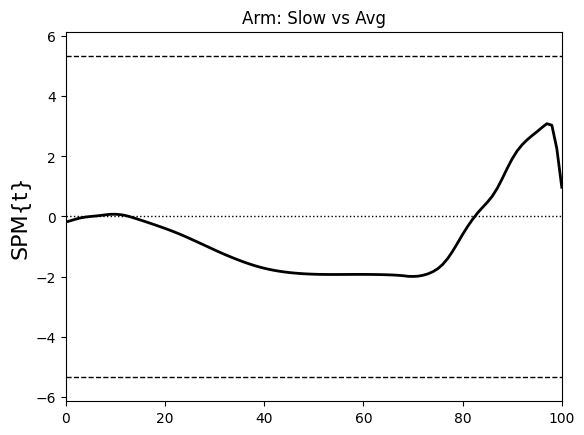

SPM{t} inference field
   SPM.z         :  (1x101) raw test stat field
   SPM.df        :  (1, 5.739)
   SPM.fwhm      :  20.01937
   SPM.resels    :  (1, 4.99516)
Inference:
   SPM.alpha     :  0.017
   SPM.zstar     :  6.58879
   SPM.h0reject  :  False
   SPM.p_set     :  1.000
   SPM.p_cluster :  ()





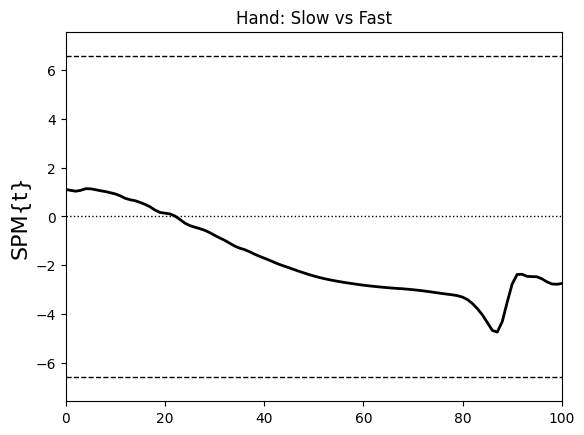

SPM{t} inference field
   SPM.z         :  (1x101) raw test stat field
   SPM.df        :  (1, 6.598)
   SPM.fwhm      :  24.66439
   SPM.resels    :  (1, 4.05443)
Inference:
   SPM.alpha     :  0.017
   SPM.zstar     :  5.60149
   SPM.h0reject  :  False
   SPM.p_set     :  1.000
   SPM.p_cluster :  ()





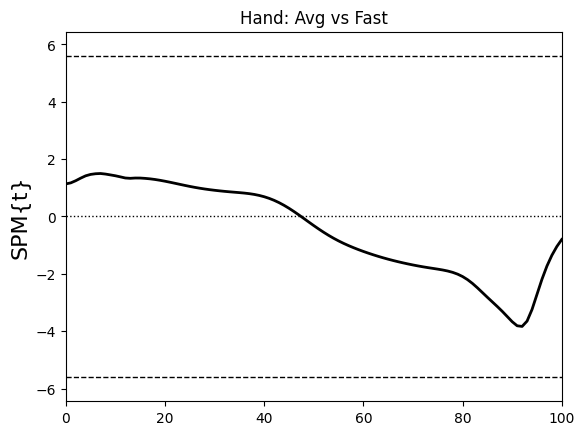

SPM{t} inference field
   SPM.z         :  (1x101) raw test stat field
   SPM.df        :  (1, 7.704)
   SPM.fwhm      :  19.24095
   SPM.resels    :  (1, 5.19725)
Inference:
   SPM.alpha     :  0.017
   SPM.zstar     :  5.28778
   SPM.h0reject  :  False
   SPM.p_set     :  1.000
   SPM.p_cluster :  ()





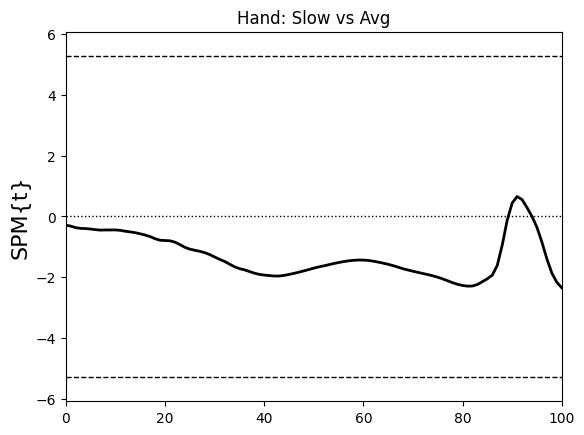

SPM{t} inference field
   SPM.z         :  (1x101) raw test stat field
   SPM.df        :  (1, 6.788)
   SPM.fwhm      :  18.07212
   SPM.resels    :  (1, 5.53339)
Inference:
   SPM.alpha     :  0.017
   SPM.zstar     :  5.83391
   SPM.h0reject  :  False
   SPM.p_set     :  1.000
   SPM.p_cluster :  ()





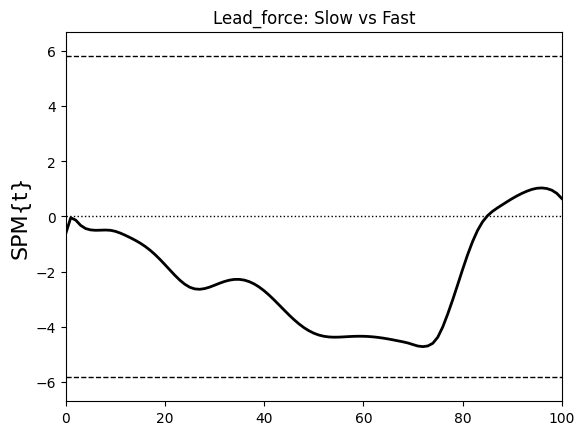

SPM{t} inference field
   SPM.z         :  (1x101) raw test stat field
   SPM.df        :  (1, 7.994)
   SPM.fwhm      :  15.48136
   SPM.resels    :  (1, 6.45938)
Inference:
   SPM.alpha     :  0.017
   SPM.zstar     :  5.37178
   SPM.h0reject  :  False
   SPM.p_set     :  1.000
   SPM.p_cluster :  ()





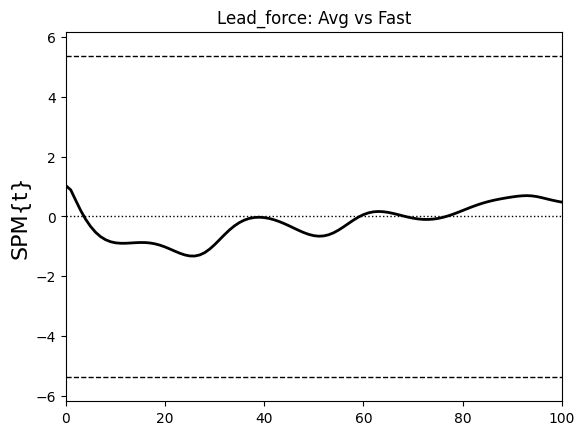

SPM{t} inference field
   SPM.z         :  (1x101) raw test stat field
   SPM.df        :  (1, 6.853)
   SPM.fwhm      :  17.54555
   SPM.resels    :  (1, 5.69945)
Inference:
   SPM.alpha     :  0.017
   SPM.zstar     :  5.82587
   SPM.h0reject  :  True
   SPM.p_set     :  0.014
   SPM.p_cluster :  (0.014)





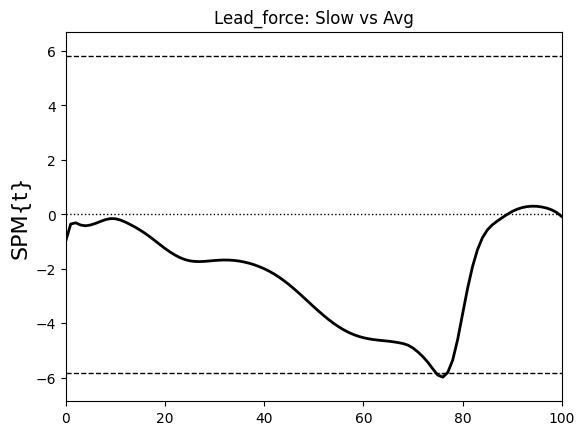

SPM{t} inference field
   SPM.z         :  (1x101) raw test stat field
   SPM.df        :  (1, 7.537)
   SPM.fwhm      :  25.00654
   SPM.resels    :  (1, 3.99895)
Inference:
   SPM.alpha     :  0.017
   SPM.zstar     :  5.11111
   SPM.h0reject  :  False
   SPM.p_set     :  1.000
   SPM.p_cluster :  ()





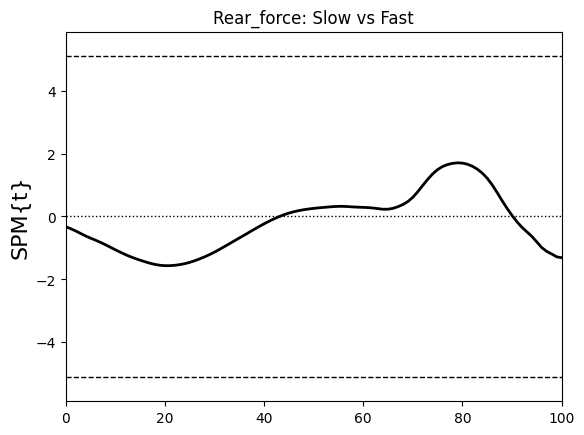

SPM{t} inference field
   SPM.z         :  (1x101) raw test stat field
   SPM.df        :  (1, 7.407)
   SPM.fwhm      :  31.23951
   SPM.resels    :  (1, 3.20107)
Inference:
   SPM.alpha     :  0.017
   SPM.zstar     :  4.95857
   SPM.h0reject  :  False
   SPM.p_set     :  1.000
   SPM.p_cluster :  ()





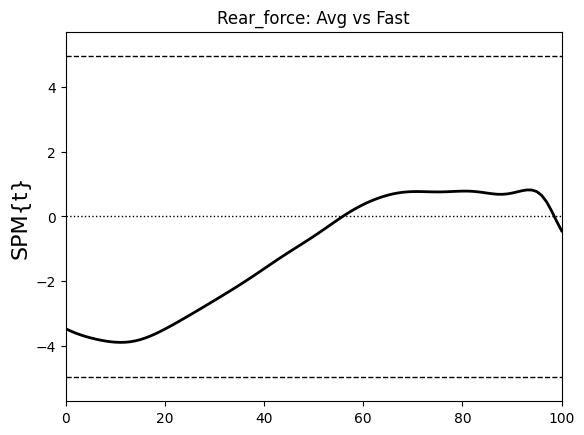

SPM{t} inference field
   SPM.z         :  (1x101) raw test stat field
   SPM.df        :  (1, 6.613)
   SPM.fwhm      :  30.03729
   SPM.resels    :  (1, 3.32920)
Inference:
   SPM.alpha     :  0.017
   SPM.zstar     :  5.37556
   SPM.h0reject  :  False
   SPM.p_set     :  1.000
   SPM.p_cluster :  ()





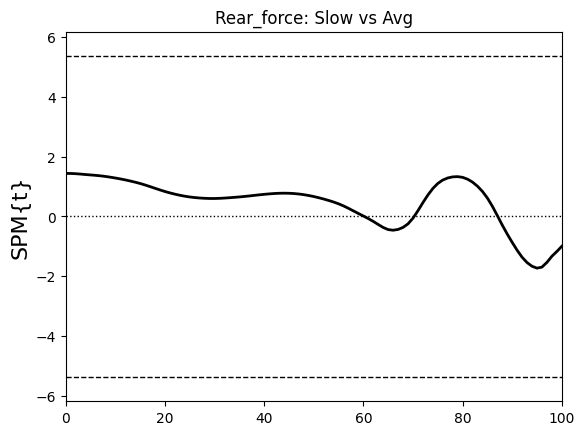

In [10]:
##Post-Hoc Testing

#Bonferroni Correction
alpha = 0.05
nTests = 3
p_critical = spm1d.util.p_critical_bonf(alpha, nTests)

def perform_ttests_velo(segment_name):
    #Extract Data for each speed
    Y1 = np.vstack([norm_velos[key].iloc[:, 1] for key in norm_velos.keys() if key[0] == 'slow' and key[2] == segment_name])
    Y2 = np.vstack([norm_velos[key].iloc[:, 1] for key in norm_velos.keys() if key[0] == 'avg' and key[2] == segment_name])
    Y3 = np.vstack([norm_velos[key].iloc[:, 1] for key in norm_velos.keys() if key[0] == 'fast' and key[2] == segment_name])
    
    #Perform pair-wise post-hoc tests
    tests = {
        f"{segment.capitalize()}: Slow vs Fast": spm1d.stats.ttest2(Y1, Y3).inference(alpha = p_critical, two_tailed = True),
        f"{segment.capitalize()}: Avg vs Fast": spm1d.stats.ttest2(Y2, Y3).inference(alpha = p_critical, two_tailed = True),
        f"{segment.capitalize()}: Slow vs Avg": spm1d.stats.ttest2(Y1, Y2).inference(alpha = p_critical, two_tailed = True)
        }
    
    # Print and plot results
    for title, test in tests.items():
        print(test)
        test.plot()
        plt.title(title)
        plt.show()

# Run tests for each segment
for segment in ['pelvis', 'torso', 'arm', 'hand']:
    perform_ttests_velo(segment)


def perform_ttests_force(force):
    #Extract Data for each speed
    Y1 = np.vstack([norm_force[key].iloc[:, 1] for key in norm_force.keys() if key[0] == 'slow' and key[1] == force])
    Y2 = np.vstack([norm_force[key].iloc[:, 1] for key in norm_force.keys() if key[0] == 'avg' and key[1] == force])
    Y3 = np.vstack([norm_force[key].iloc[:, 1] for key in norm_force.keys() if key[0] == 'fast' and key[1] == force])
    
    #Perform pair-wise post-hoc tests
    tests = {
        f"{force.capitalize()}: Slow vs Fast": spm1d.stats.ttest2(Y1, Y3).inference(alpha = p_critical, two_tailed = True),
        f"{force.capitalize()}: Avg vs Fast": spm1d.stats.ttest2(Y2, Y3).inference(alpha = p_critical, two_tailed = True),
        f"{force.capitalize()}: Slow vs Avg": spm1d.stats.ttest2(Y1, Y2).inference(alpha = p_critical, two_tailed = True)
        }
    
    # Print and plot results
    for title, test in tests.items():
        print(test)
        test.plot()
        plt.title(title)
        plt.show()

# Run tests for each segment
for force in ['lead_force', 'rear_force']:
    perform_ttests_force(force)

**After adjusting for multiple comparisons, post-hoc testing revealed that the significant differences were in lower magnitudes of segment angular velocities in the average exit velocity group vs. the fast velocity group.**
**This further cements that increases in the magnitude of segment angular velocities are also related to increases in exit velocity.**

# Takeaways
##### There were some interesting takeaways that were found from this mini-project:

##### *1. Pelvis / Torso / Hand Segment Angular Velocities*: Unsurprisingly greater angular velocities in the pelvis, torso, and hand segments resulted in greater exit velocities! 
##### *Implication*: When training to increase power production in hitting, increases in variables such as pelvis, torso, and hand segment angular velocities can be useful metrics to gauge progress.

##### *2. Kinematic Sequencing and Variability*: From visualizing the differences in the 3 groups, there is a clear relationship between increasing exit velocity and decreasing variability in the magnitude and timing of the sequencing of peak angular velocities.
##### *Implication*: When developing athletes, visualizing the sequencing of their peak angular velocities over multiple swings can reveal insights on their coordination, movement variability, and whether they are sequencing efficiently. Training plans can then be developed to target areas that may be lacking, while refining what they are already doing well. 

##### *3. SPM to analyse the whole signal*: This was my first foray into using SPM to analyse a full time-varying signal and I found that while being relatively simple to implement, the amount of information that was gained was extraordinary! 
##### *Implication*: The use of SPM specifically in baseball biomechanics can allow the analysis of the full time-varying signal and reveal significant points in the phases of a baseball swing or pitch that may be relevant to performance (something that a summary statistic would most likely miss). 
